In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch

In [ ]:
import torch

In [ ]:
!pip install imbalanced-learn

# Step - 1:

Epoch 1/50, Train Loss: 1.0798259280694535, Train Accuracy: 0.5985520094562647, Validation Loss: 0.8928908748575407, Validation Accuracy: 0.6845371929983665
Epoch 2/50, Train Loss: 0.8694222769170209, Train Accuracy: 0.6857727874266095, Validation Loss: 0.7088194551412543, Validation Accuracy: 0.7745371819387319
Epoch 3/50, Train Loss: 0.6964940016938388, Train Accuracy: 0.7856581691393079, Validation Loss: 0.580322247496379, Validation Accuracy: 0.819894955590037
Epoch 4/50, Train Loss: 0.6197253122684968, Train Accuracy: 0.8087848925107858, Validation Loss: 0.5213671801643422, Validation Accuracy: 0.839233832749569
Epoch 5/50, Train Loss: 0.5718994062038457, Train Accuracy: 0.821289194537655, Validation Loss: 0.48389700628260185, Validation Accuracy: 0.8458209511506997
Epoch 6/50, Train Loss: 0.5376127041037946, Train Accuracy: 0.8306322750347235, Validation Loss: 0.4648887265013744, Validation Accuracy: 0.8518307566227857
Epoch 7/50, Train Loss: 0.5121218373362163, Train Accuracy: 0

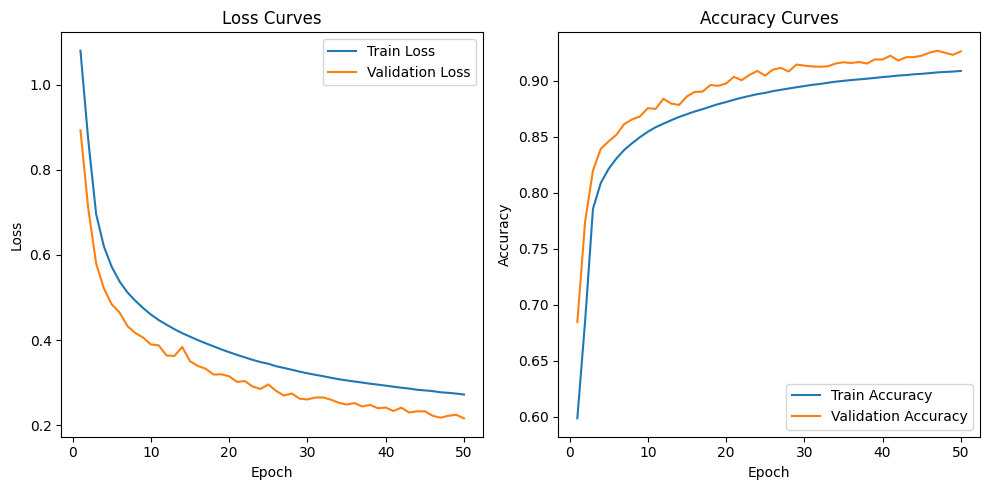

Test Accuracy: 0.9259947420983383


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# graph
import seaborn as sns
import matplotlib.pyplot as plt

# # mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# load dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/CSCI_6379/CIC-IoT-2023_merged dataset/merged_data.csv'
df = pd.read_csv(dataset_path)

# Assuming 'label' is the target column
X = df.drop('label', axis=1)
y = df['label']

# Use only 10% of the dataset
X, _, y, _ = train_test_split(X, y, test_size=0.95, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resample the data to address class imbalance
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split the resampled dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.57, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        x = self.fc1(hidden.squeeze(0))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = LSTMModel(X_train.shape[1], 128, len(label_encoder.classes_))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Lists to store training and validation history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    # Evaluate the model on validation set
    model.eval()
    val_loss_epoch = 0
    val_correct = 0
    val_total = 0
    for inputs, labels in val_loader:
        with torch.no_grad():
            outputs = model(inputs.unsqueeze(1))
            val_loss = criterion(outputs.squeeze(1), labels)
            val_loss_epoch += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.unsqueeze(1))
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test, predicted.numpy())

print(f'Test Accuracy: {test_accuracy}')


## Step 2 - 86%

Epoch 1/50, Loss: 0.9138061591468342, Training Accuracy: 0.6582021727284274, Validation Loss: 0.914836284967133, Validation Accuracy: 0.6588102708615123
Epoch 2/50, Loss: 0.8232337508629376, Training Accuracy: 0.7209861577164022, Validation Loss: 0.8248479654622239, Validation Accuracy: 0.7212916768507469
Epoch 3/50, Loss: 0.7669997776913242, Training Accuracy: 0.7595755948064292, Validation Loss: 0.7690023632545029, Validation Accuracy: 0.7597559802209494
Epoch 4/50, Loss: 0.7403554578327829, Training Accuracy: 0.7634448582584575, Validation Loss: 0.7428331375543961, Validation Accuracy: 0.7635560706887609
Epoch 5/50, Loss: 0.7092700079198221, Training Accuracy: 0.7766638601062805, Validation Loss: 0.7111037525760763, Validation Accuracy: 0.7768420098010482
Epoch 6/50, Loss: 0.6959206399310713, Training Accuracy: 0.7900439318886717, Validation Loss: 0.6978134424810636, Validation Accuracy: 0.7904873870396565
Epoch 7/50, Loss: 0.6609992516041193, Training Accuracy: 0.8020130412871664, 

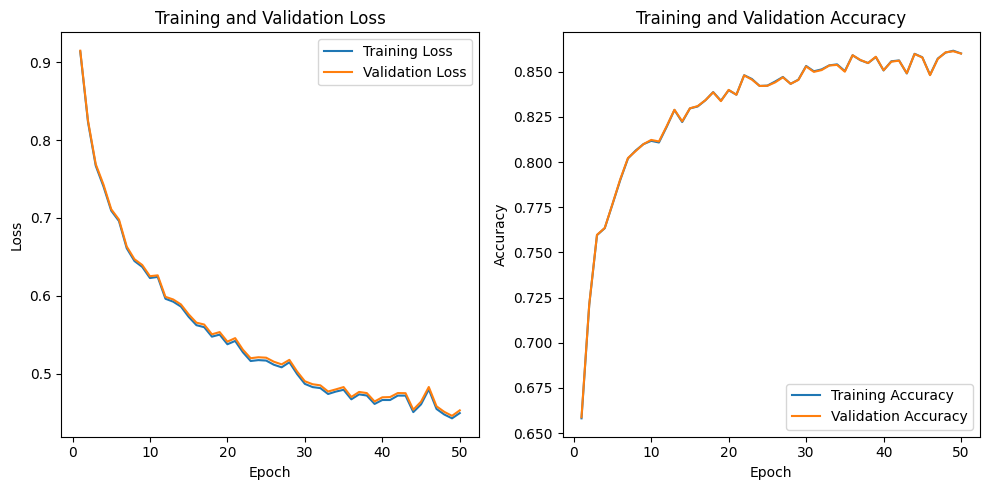

Test Accuracy: 0.8597128094398607


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# graph
import seaborn as sns
import matplotlib.pyplot as plt

# mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# load dataset
dataset = '/content/drive/MyDrive/Colab Notebooks/CSCI_6379/CIC-IoT-2023_merged dataset/merged_data.csv'
df = pd.read_csv(dataset)

# Assuming 'label' is the target column
X = df.drop('label', axis=1)
y = df['label']

# Use only 10% of the dataset
X, _, y, _ = train_test_split(X, y, test_size=0.95, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resample the data to address class imbalance
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split the resampled dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.57, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128, shuffle=False)

# Define the Feed Forward Neural Network (FNN) model class
class FNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = FNNModel(X_train.shape[1], 128, len(label_encoder.classes_))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on validation set
    model.eval()
    val_loss_epoch = 0
    val_correct = 0
    val_total = 0
    for inputs, labels in val_loader:
        with torch.no_grad():
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_loss_epoch += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader)
    avg_val_accuracy = val_correct / val_total

    # Evaluate the model on training set
    train_correct = 0
    train_total = 0
    train_loss_epoch = 0
    for inputs, labels in train_loader:
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss = criterion(outputs, labels)
            train_loss_epoch += train_loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader)
    avg_train_accuracy = train_correct / train_total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

    # Store the loss and accuracy for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)

# Plotting loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test, predicted.numpy())

print(f'Test Accuracy: {test_accuracy}')


# Step 3

Epoch 1/50, Loss: 0.8037835818329092, Training Accuracy: 0.6880136824940284, Validation Loss: 0.8051727043205318, Validation Accuracy: 0.6877655003544613
Epoch 2/50, Loss: 0.7205504414825209, Training Accuracy: 0.7303991461500957, Validation Loss: 0.7223008242293365, Validation Accuracy: 0.7299712781287983
Epoch 3/50, Loss: 0.6899062566220854, Training Accuracy: 0.7302795600460522, Validation Loss: 0.6914504431314673, Validation Accuracy: 0.7296981051527944
Epoch 4/50, Loss: 0.6622660395420217, Training Accuracy: 0.7352402067431199, Validation Loss: 0.6633170404358602, Validation Accuracy: 0.7349094050027152
Epoch 5/50, Loss: 0.6340655676188366, Training Accuracy: 0.7526447222324651, Validation Loss: 0.6352965000464179, Validation Accuracy: 0.752365932343791
Epoch 6/50, Loss: 0.6272987273971511, Training Accuracy: 0.753436500034826, Validation Loss: 0.6287532932761032, Validation Accuracy: 0.7531201994273321
Epoch 7/50, Loss: 0.7498760373884931, Training Accuracy: 0.7265519049784693, V

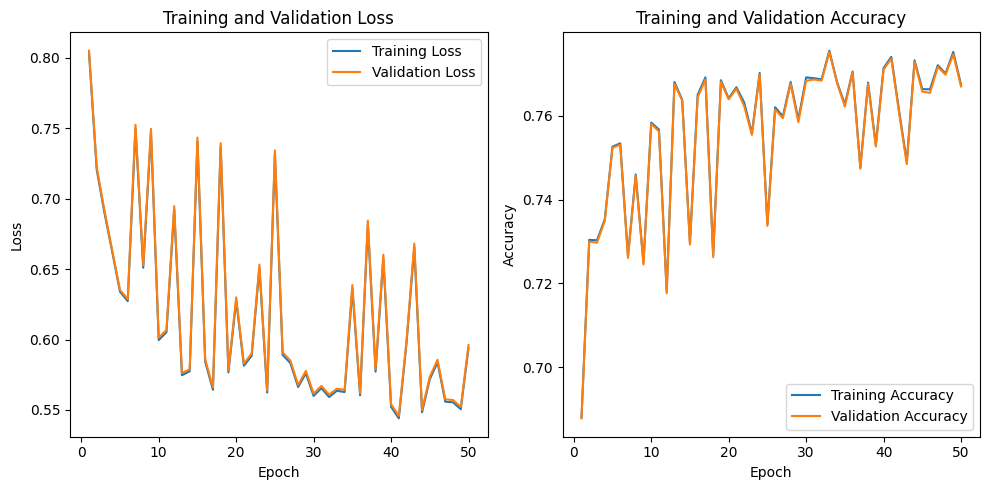

Test Accuracy: 0.7670687823977934


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# graph
import seaborn as sns
import matplotlib.pyplot as plt

# mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# load dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/CSCI_6379/CIC-IoT-2023_merged dataset/merged_data.csv'
df = pd.read_csv(dataset_path)

# Assuming 'label' is the target column
X = df.drop('label', axis=1)
y = df['label']

# Use only 10% of the dataset
X, _, y, _ = train_test_split(X, y, test_size=0.95, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resample the data to address class imbalance
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split the resampled dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.57, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=512, shuffle=False)

class RandomNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RandomNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Instantiate the model
model = RandomNNModel(X_train.shape[1], 512, len(label_encoder.classes_))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on validation set
    model.eval()
    val_loss_epoch = 0
    val_correct = 0
    val_total = 0
    for inputs, labels in val_loader:
        with torch.no_grad():
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_loss_epoch += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader)
    avg_val_accuracy = val_correct / val_total

    # Evaluate the model on training set
    train_correct = 0
    train_total = 0
    train_loss_epoch = 0
    for inputs, labels in train_loader:
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss = criterion(outputs, labels)
            train_loss_epoch += train_loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader)
    avg_train_accuracy = train_correct / train_total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

    # Store the loss and accuracy for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)

# Plotting loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test, predicted.numpy())

print(f'Test Accuracy: {test_accuracy}')